## To do

- Agree on a title naming approach (e.g. do we keep "Laugh test X:", do we want to include the main reference in the title)
- Check the expectations for this laugh test and update the image accordingly
- Agree on what constitutes relevant meta data for these things
- Update results with Reza's new ones
- Do we want the code to be more elegant in terms of extracting length of data series, convert time from the .nc attributes etc?
- Image format and specs?

# Laugh test 1: Storage and transmission in soils
This notebook plots SUMMA simulations for the test case defined in Celia et al. (1990). 

## Expectations
The simulations should reproduce Figure 6 in Celia et al. (1990):

<div>
<img src="img/celia1990_fig6.png" width="250"/>
    <center> Figure 6a in Celia et al. (1990) </center>
</div>

## Workflow
- Load model simulations (.nc) into memory
- Extract `mLayerMatricHead` and `mLayerVolFracLiq` variables for times `10`, `32` and `49`
- Create a plot of pressure head vs depth, for the selected times

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |   |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | M. Clark |
| Model decisions | see attributes in output.nc  |
| Model run date | see attributes in output.nc |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Celia, M. A., E. T. Bouloutas, and R. L. Zarba (1990), A general mass conservative numerical solution for the unsaturated flow equation, Water Resour. Res., 26(7), 1483–1496, doi:10.1029/WR026i007p01483

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

In [8]:
# modules
from pathlib import Path
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt

In [9]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_name = "celia1990_output_timestep.nc"

In [10]:
# Load the data
ds = xr.open_dataset( sim_path / sim_name )

In [11]:
# Extract the variables we want
matricHead = ds.mLayerMatricHead
layerHeight = ds.mLayerHeight

In [12]:
# Select the time slices of interest
matricHead_t10 = matricHead.isel(time=10)
matricHead_t32 = matricHead.isel(time=32)
matricHead_t49 = matricHead.isel(time=49)

layerHeight_t10 = layerHeight.isel(time=10)
layerHeight_t32 = layerHeight.isel(time=32)
layerHeight_t39 = layerHeight.isel(time=49)

In [13]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

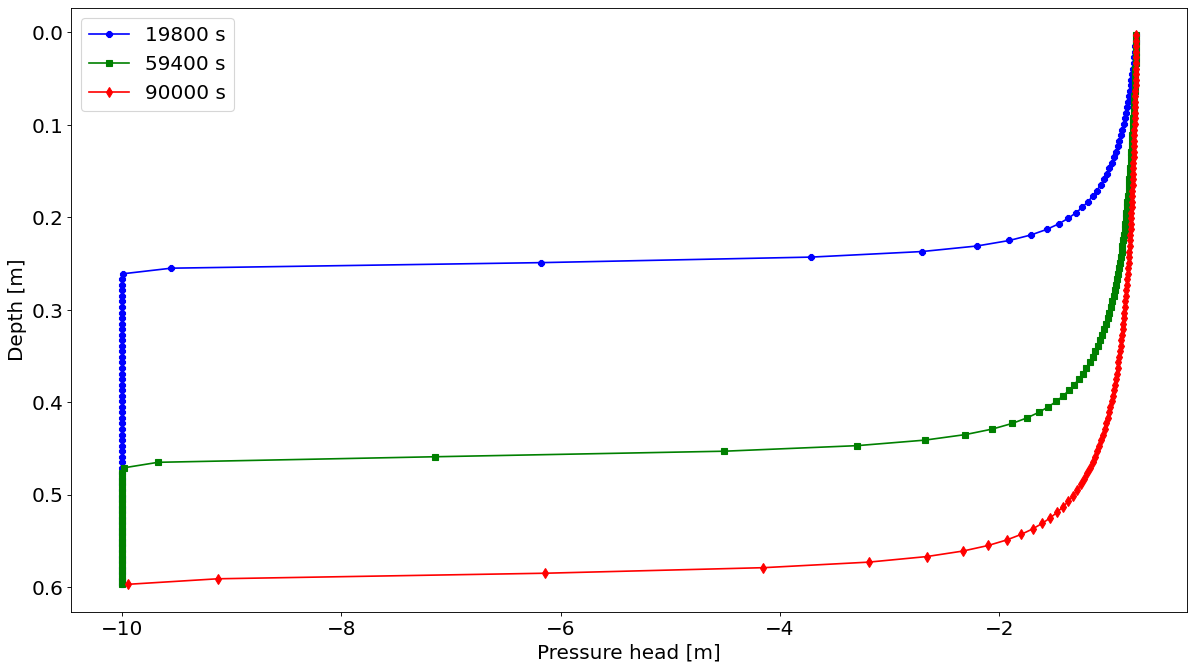

In [16]:
# Open a figure
fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k');

# Plot the data in a single figure
plt.plot(matricHead_t10[0:100], layerHeight_t10[0:100], marker='8', color='blue',  label='19800 s')
plt.plot(matricHead_t32[0:100], layerHeight_t32[0:100], marker='s', color='green', label='59400 s')
plt.plot(matricHead_t49[0:100], layerHeight_t39[0:100], marker='d', color='red',   label='90000 s')

# Make sure that increasing depth points downward
plt.gca().invert_yaxis()

# Labels
plt.xlabel('Pressure head [m]'); # note, ';' supresses output from the Text object that is created for the labels
plt.ylabel('Depth [m]');
plt.legend();

# Save the figure
plt.savefig('img/lt1_celia1990.png');